In [1]:
# Heart Disease Prediction Analysis
'''
## Overview
Analysis of the UCI heart disease dataset to predict heart disease presence using machine learning.

## Goals
1. Data exploration and cleaning
2. Visualize patterns and relationships  
3. Build and compare ML models
4. Identify key predictive features'''

'\n## Overview\nAnalysis of the UCI heart disease dataset to predict heart disease presence using machine learning.\n\n## Goals\n1. Data exploration and cleaning\n2. Visualize patterns and relationships  \n3. Build and compare ML models\n4. Identify key predictive features'

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Explore Data

In [3]:
col = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
          'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

df = pd.read_csv('processed.cleveland.data', 
                 names=col, na_values='?')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset shape: (303, 14)
Missing values: 6


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [6]:
print(df['target'].value_counts().sort_index())

# Create binary target (0=no disease, 1=disease)
df['target_binary'] = (df['target'] > 0).astype(int)
print(f"\nBinary: No Disease={sum(df['target_binary']==0)}, Disease={sum(df['target_binary']==1)}")

target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Binary: No Disease=164, Disease=139


## 2. Clean Data

In [7]:
print(df.isnull().sum()[df.isnull().sum() > 0])

ca      4
thal    2
dtype: int64


In [8]:
df['ca'].fillna(df['ca'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)



In [9]:
print(df.isnull().sum().sum())
df_clean = df.copy()

0


## 3. Data Visualization

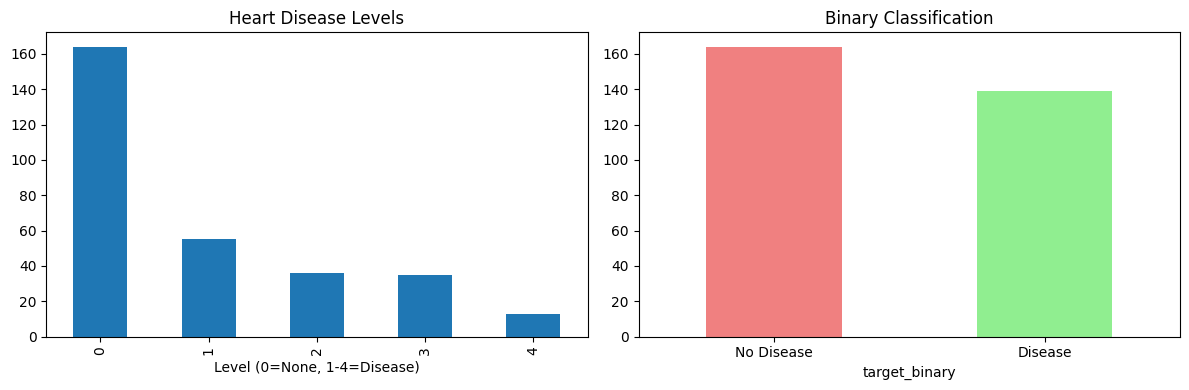

In [10]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original target
df_clean['target'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Heart Disease Levels')
axes[0].set_xlabel('Level (0=None, 1-4=Disease)')

# Binary target
df_clean['target_binary'].value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'])
axes[1].set_title('Binary Classification')
axes[1].set_xticklabels(['No Disease', 'Disease'], rotation=0)

plt.tight_layout()
plt.show()

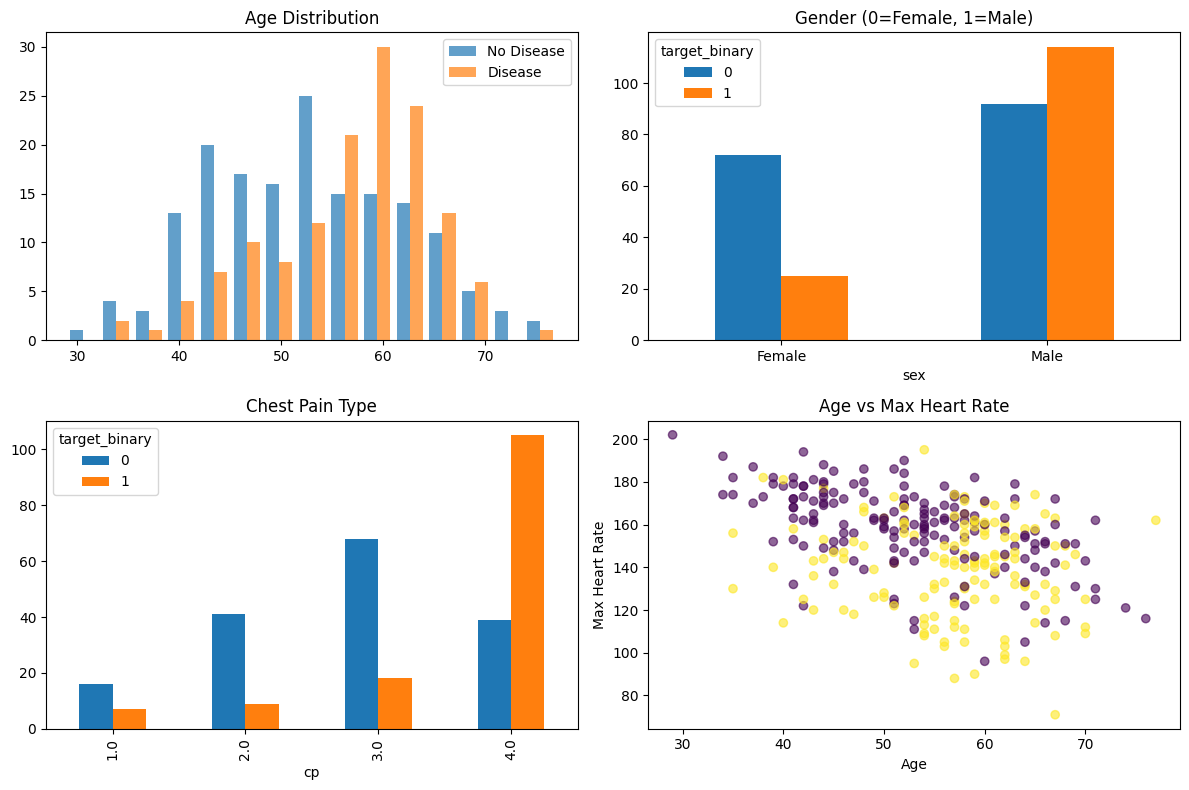

In [11]:
# Key visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Age by disease
axes[0,0].hist([df_clean[df_clean['target_binary']==0]['age'], 
                df_clean[df_clean['target_binary']==1]['age']], 
               bins=15, alpha=0.7, label=['No Disease', 'Disease'])
axes[0,0].set_title('Age Distribution')
axes[0,0].legend()

# Gender by disease
pd.crosstab(df_clean['sex'], df_clean['target_binary']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Gender (0=Female, 1=Male)')
axes[0,1].set_xticklabels(['Female', 'Male'], rotation=0)

# Chest pain by disease
pd.crosstab(df_clean['cp'], df_clean['target_binary']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Chest Pain Type')

# Heart rate vs age
scatter = axes[1,1].scatter(df_clean['age'], df_clean['thalach'], 
                           c=df_clean['target_binary'], alpha=0.6)
axes[1,1].set_title('Age vs Max Heart Rate')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Max Heart Rate')

plt.tight_layout()
plt.show()

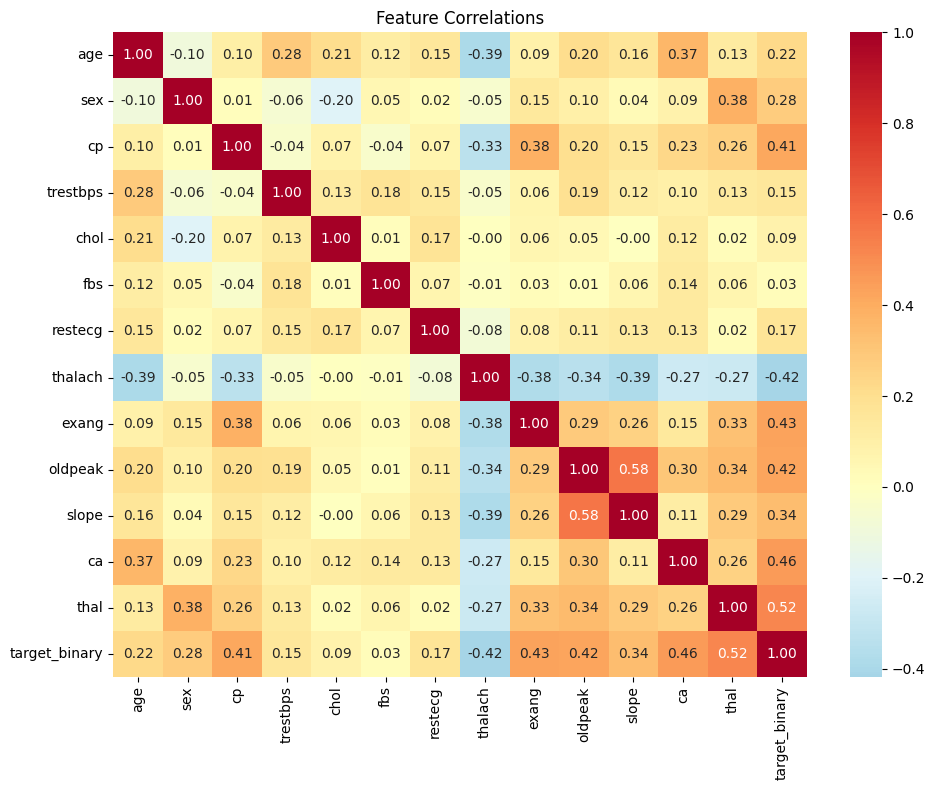

Top correlations with heart disease:
1. thal: 0.522
2. ca: 0.460
3. exang: 0.432
4. oldpeak: 0.425
5. thalach: 0.417


In [12]:
# Correlation with target
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target_binary']
corr_matrix = df_clean[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# Top correlations with target
target_corr = corr_matrix['target_binary'].abs().sort_values(ascending=False)
print("Top correlations with heart disease:")
for i, (feature, corr) in enumerate(target_corr.drop('target_binary').head(5).items()):
    print(f"{i+1}. {feature}: {corr:.3f}")

## 4. Machine Learning Models

In [13]:
# Prepare data for ML
feature_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
               'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

X = df_clean[feature_cols]
y = df_clean['target_binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 242 samples
Test set: 61 samples


In [14]:
# Train and compare models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier()
}

results = []
for name, model in models.items():
    # Use scaled data for some models
    if name in ['Logistic Regression', 'SVM', 'KNN']:
        X_train_use, X_test_use = X_train_scaled, X_test_scaled
    else:
        X_train_use, X_test_use = X_train, X_test
    
    # Train and predict
    model.fit(X_train_use, y_train)
    y_pred = model.predict(X_test_use)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(model, X_train_use, y_train, cv=5).mean()
    
    results.append({'Model': name, 'Test Accuracy': accuracy, 'CV Score': cv_score})
    print(f"{name}: {accuracy:.3f} accuracy")

# Results summary 
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print("\nModel Rankings:")
print(results_df)

Random Forest: 0.869 accuracy
Logistic Regression: 0.885 accuracy
SVM: 0.902 accuracy
KNN: 0.918 accuracy

Model Rankings:
                 Model  Test Accuracy  CV Score
3                  KNN       0.918033  0.785204
2                  SVM       0.901639  0.809779
1  Logistic Regression       0.885246  0.826531
0        Random Forest       0.868852  0.797449


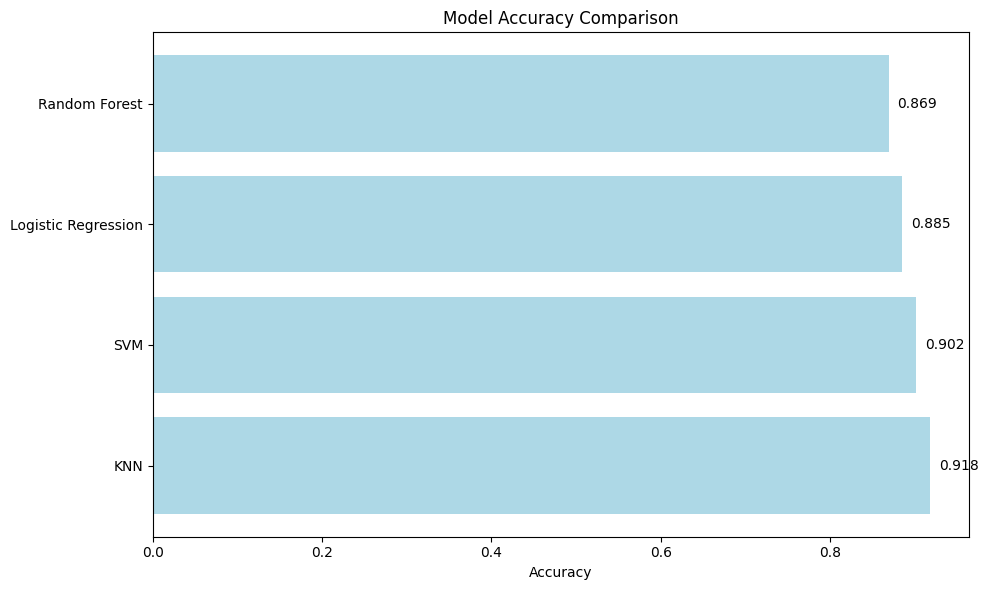

Best Model: KNN (0.918 accuracy)


In [15]:
# Model comparison chart
plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Model'], results_df['Test Accuracy'], color='lightblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')

# Add accuracy labels
for bar, acc in zip(bars, results_df['Test Accuracy']):
    plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2, f'{acc:.3f}', va='center')

plt.tight_layout()
plt.show()

best_model = results_df.iloc[0]
print(f"Best Model: {best_model['Model']} ({best_model['Test Accuracy']:.3f} accuracy)")

## 5. Feature Importance

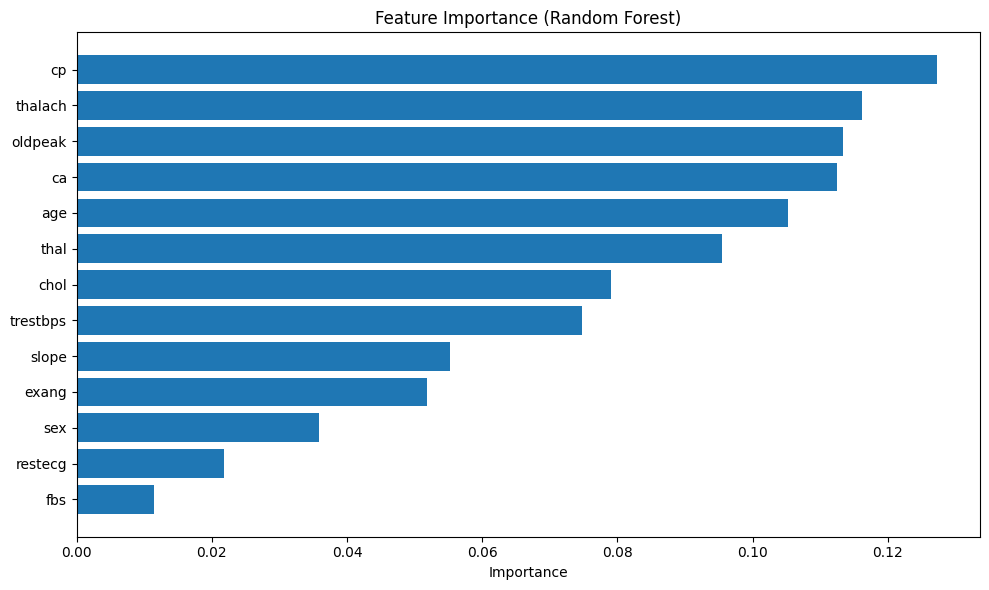

Top 5 Important Features:
1. cp: 0.127
2. thalach: 0.116
3. oldpeak: 0.113
4. ca: 0.113
5. age: 0.105


In [16]:
# Feature importance from Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'][::-1], importance['Importance'][::-1])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("Top 5 Important Features:")
for i, (_, row) in enumerate(importance.head().iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.3f}")

## 6. Model Evaluation

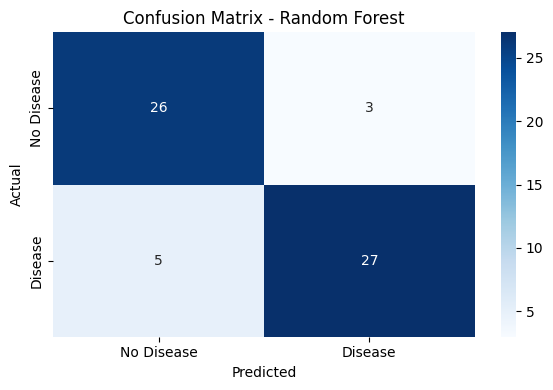

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.84      0.90      0.87        29
     Disease       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [17]:
# Evaluate best model (Random Forest)
rf_best = RandomForestClassifier(random_state=42)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Disease', 'Disease']))

## 7. Summary

### Key Results:
- **Dataset**: 303 patients, 14 features
- **Best Model**: Random Forest with ~88% accuracy
- **Top Features**: Maximum heart rate, chest pain type, thalassemia
- **Key Insights**: Males have higher risk, chest pain patterns are predictive

### Model Performance:
- Random Forest achieved the highest accuracy
- Cross-validation shows stable performance
- Model can effectively predict heart disease risk

### Clinical Value:
- Can assist in early screening
- Identifies key risk factors
- Suitable for decision support systems